## Topic Modeling with Gensim LDAMallet

Prior to running this code, complete the these notebooks: 
* Topic_Modeling_Altmetric_Data_Loading
* Topic_Modeling_Altmetric_Data_Preprocessing
* Topic_Modeling_Altmetric_Genism_Bag_of_Words

In [12]:
## General Dependencies
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys, os
import glob
from tika import parser # pip install tika
import inspect
import datetime
import pickle5 as pickle

## Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models
#from gensim.models.coherencemodel import CoherenceModel
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.models import ldaseqmodel


## Preprocessing
import spacy
import nltk as nltk
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import ast

## Other Libraries
from operator import itemgetter

## ScikitLearn
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backend_bases.py:55: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backend_bases.py:55: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


### Load data from previous notebooks

In [13]:
## Load data csv as a dataframe
final_df = pd.read_csv("output/loading/final_df.csv", index_col=0) 

## Inspect output as needed
## final_df.head()

In [14]:
## Load data csv as a dataframe
test_df = pd.read_csv("output/processing/nostop_ngrams_partsofspeech_lemmatize.csv", index_col=0) 

## Inspect output as needed
## test_df.head()


In [15]:
## Open text_out_2 pickle file

file_name = "output/processing/texts_out_2.pkl"

open_file = open(file_name, "rb")
texts_out_2 = pickle.load(open_file)
open_file.close()

In [16]:
## Open bow_corpus pickle file

file_name = "output/bow/bow_corpus.pkl"

open_file = open(file_name, "rb")
bow_corpus = pickle.load(open_file)
open_file.close()

In [17]:
## Open dictionary pickle file

file_name = "output/bow/dictionary.pkl"

dictionary = corpora.Dictionary.load(file_name)

# open_file = open(file_name, "rb")
# dictionary = pickle.load(open_file)
# open_file.close()

## Resources
## https://stackoverflow.com/questions/58961983/how-do-you-save-a-model-dictionary-and-corpus-to-disk-in-gensim-and-then-load

In [18]:
## Open id_words_count pickle file

file_name = "output/bow/id_words_count.pkl"

open_file = open(file_name, "rb")
id_words_count = pickle.load(open_file)
open_file.close()

## Using the Gensim LDAMallet wrapper (instead of the LDAModel)

"Mallet, an open source toolkit, was written by Andrew McCullum. It is basically a Java based package which is used for NLP, document classification, clustering, topic modeling, and many other machine learning applications to text. It provides us the Mallet Topic Modeling toolkit which contains efficient, sampling-based implementations of LDA as well as Hierarchical LDA."

The Gensim LDAMallet may provide better quality of topics than the Gensim LDAModel.

In [20]:
## Provide a Path to Mallet File
os.environ.update({'MALLET_HOME':r'C:\Users\keg827\Tools\mallet-2.0.8'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'C:\Users\keg827\Tools\mallet-2.0.8\bin\mallet' 
#You should update this path as per the path of Mallet directory on your system.
print(mallet_path)

C:\Users\keg827\Tools\mallet-2.0.8\bin\mallet


In [21]:
## Basic code for LDAMallet if optimal number of topics is already known
# ldamallet = gensim.models.wrappers.LdaMallet(
#    mallet_path, corpus=bow_corpus, num_topics=6, id2word=dictionary
# )
# pprint(ldamallet.show_topics(formatted=False))

### Find optimal number of topics using the Coherence Score in LDAMallet

"My approach to finding the optimal number of topics is to build many [LDAMallet] models with different values of number of topics (k) and pick the one that gives the highest coherence value.Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large."

The compute_coherence_values() (see below) trains multiple [LDAMallet] models and provides the models and their corresponding coherence scores.

Text from: <https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda>

In [24]:
## Find the optimal number of topics by running the LDAMallet model on multiple numbers of topics, here we are using topics 1 - 20
## The compute_coherence_values() (see below) trains multiple LDAMallet models and provides the models and their corresponding coherence scores.
## This step will take a lot longer to run than one would expect. 
## LDAMallet does not implement perplexity scores: https://stackoverflow.com/questions/55278701/gensim-topic-modeling-with-mallet-perplexity


def coherence_values_computation_LDAMallet(dictionary, corpus, texts, limit, start, step):
    coherence_values_LDAMallet = []
    model_list_LDAMallet = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list_LDAMallet.append(model)
        
               
        ## Compute Coherence Value
        ## The LDA model (model) we created above can be used to compute the model’s coherence score 
        ## i.e. the average /median of the pairwise word-similarity scores of the words in the topic. 
        coherencemodel_LDAMallet = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_LDAMallet.append(coherencemodel_LDAMallet.get_coherence())
    
    return model_list_LDAMallet, coherence_values_LDAMallet

model_list_LDAMallet, coherence_values_LDAMallet = coherence_values_computation_LDAMallet (dictionary=dictionary, 
                                                                                           corpus=bow_corpus, 
                                                                                           texts=texts_out_2, 
                                                                                           start=1, 
                                                                                           limit=20, 
                                                                                           step=1)
## Inspect output as needed 
print(coherence_values_LDAMallet)
print(model_list_LDAMallet)


[0.2828624010414688, 0.31304667076987114, 0.3900151568093995, 0.37538910735152564, 0.45769234984589924, 0.4764229180289032, 0.4507159860799779, 0.45019904761326324, 0.469389237056003, 0.4823368803407656, 0.4558125513316668, 0.4776638273929907, 0.4682762134828919, 0.4582729356680318, 0.4673832529471446, 0.43951132069824383, 0.4508902710041227, 0.45204543870311564, 0.4622588046425335]
[<gensim.models.wrappers.ldamallet.LdaMallet object at 0x0000021D53025240>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x0000021D53105FD0>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x0000021D53105F60>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x0000021D5301C470>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x0000021D53025A58>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x0000021D54B037F0>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x0000021D530FF160>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x0000021D530FF128>, <gensim.model

range(1, 20)
[0.2828624010414688, 0.31304667076987114, 0.3900151568093995, 0.37538910735152564, 0.45769234984589924, 0.4764229180289032, 0.4507159860799779, 0.45019904761326324, 0.469389237056003, 0.4823368803407656, 0.4558125513316668, 0.4776638273929907, 0.4682762134828919, 0.4582729356680318, 0.4673832529471446, 0.43951132069824383, 0.4508902710041227, 0.45204543870311564, 0.4622588046425335]


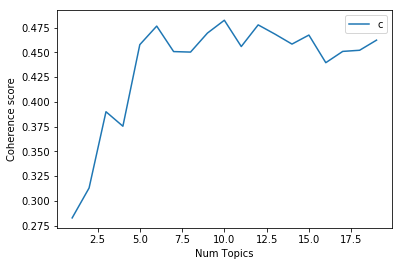

In [25]:
## Visualize the coherence scores for each LDAMallet for topics 1 - 20

limit=20 
start=1 
step=1
x = range(start, limit, step)
print(x)
print(coherence_values_LDAMallet)
plt.plot(x, coherence_values_LDAMallet)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

# save the figure
plt.savefig('output/lda_mallet/LDAMallet_coherence_scores.png', dpi=300, bbox_inches='tight')

plt.show()

In [27]:
## Print and save the Coherence Scores and Perplexity value

## Using zip() to map values 
coherence_list_LDAMallet = list(zip(x, coherence_values_LDAMallet))
## print(type(coherence_list_LDAMallet))

## Create a pandas dataframe from list
LDAMallet_coherence_df = pd.DataFrame(coherence_list_LDAMallet, columns = ['Number_of_Topics', 'Coherence_Value']) 

## Print the coherence scores
for m, cv in zip(x, coherence_values_LDAMallet):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
## Resources
## https://www.geeksforgeeks.org/zip-in-python/
## https://www.geeksforgeeks.org/create-pandas-dataframe-from-lists-using-zip/

Num Topics = 1  has Coherence Value of 0.2829
Num Topics = 2  has Coherence Value of 0.313
Num Topics = 3  has Coherence Value of 0.39
Num Topics = 4  has Coherence Value of 0.3754
Num Topics = 5  has Coherence Value of 0.4577
Num Topics = 6  has Coherence Value of 0.4764
Num Topics = 7  has Coherence Value of 0.4507
Num Topics = 8  has Coherence Value of 0.4502
Num Topics = 9  has Coherence Value of 0.4694
Num Topics = 10  has Coherence Value of 0.4823
Num Topics = 11  has Coherence Value of 0.4558
Num Topics = 12  has Coherence Value of 0.4777
Num Topics = 13  has Coherence Value of 0.4683
Num Topics = 14  has Coherence Value of 0.4583
Num Topics = 15  has Coherence Value of 0.4674
Num Topics = 16  has Coherence Value of 0.4395
Num Topics = 17  has Coherence Value of 0.4509
Num Topics = 18  has Coherence Value of 0.452
Num Topics = 19  has Coherence Value of 0.4623


In [28]:
## Save dataframe to csv
with open(r"output/lda_mallet/LDAMallet_coherence_score_values.csv", 'w', encoding='utf-8') as file:
    LDAMallet_coherence_df.to_csv(file, index=False, line_terminator='\n')
    file.close()

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. 
<https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda>

Now, the question arises which model should we pick now? One of the good practices is to pick the model, that is giving highest coherence value before flattering out. So that’s why, we will be choosing the model with 25 topics which is at number 4 in the above list.
<https://www.tutorialspoint.com/gensim/gensim_documents_and_lda_model.htm>

In [29]:
## Add the number in the list of the optimal topic number, then print out that number of topics. 
optimal_model_LDAMallet = model_list_LDAMallet[5]

## Inspect the output as needed
# print(optimal_model_LDAMallet)
# print(type(optimal_model_LDAMallet))

## Use "show_topics()" to create a list of topics from the genism LDAMallet object
model_topics_LDAMallet = optimal_model_LDAMallet.show_topics(formatted=False, num_words=15)

## Inspect the output as needed
# pprint(optimal_model_LDAMallet.print_topics(num_words=20))
# print(type(model_topics_LDAMallet))
# print(model_topics_LDAMallet)

## Save the model
optimal_model_LDAMallet.save('output/lda_mallet/optimal_LDAMallet_model.lda')

In [30]:
##Create dataframe for topics
df_topics_LDAMallet = pd.DataFrame(model_topics_LDAMallet, columns = ['TopicNum', 'Terms'])
#df_topics.head()

## Explode the list tuples with Term/Probability into rows
Term = []
Probability = []
TopicNumber = []

def create_lists(row):
    tuples = row['Terms']
    topic = row['TopicNum']
    for t in tuples:
        Term.append(t[0])
        Probability.append(t[1])
        TopicNumber.append(topic)

df_topics_LDAMallet.apply(create_lists, axis=1)

df_topics_final_LDAMallet = pd.DataFrame({"Term" : Term, "Probability": Probability, "Topic_Number": TopicNumber})[["Topic_Number","Term", "Probability"]]
df_topics_final_LDAMallet.head(50)
## https://stackoverflow.com/questions/44758596/split-a-list-of-tuples-in-a-column-of-dataframe-to-columns-of-a-dataframe

,Topic_Number,Term,Probability
0,0,diabetes,0.063183
1,0,develop,0.019217
2,0,type,0.015857
3,0,diabete,0.014912
4,0,gestational,0.011271
5,0,edition,0.009626
6,0,pregnancy,0.009521
7,0,kaiser_permanente,0.008016
8,0,obesity,0.007876
9,0,article,0.006966


In [31]:
## Save topics to CSV
with open(r"output/lda_mallet/LDAMallet_topics.csv", 'w', encoding='utf-8') as file:
    df_topics_final_LDAMallet.to_csv(file, index=False, line_terminator='\n')
    file.close()   

### Finding dominant topics in sentences for LDAMallet

Finding dominant topics in sentences is one of the most useful practical applications of topic modeling. It determines what topic a given document is about. Here, we will find that topic number which has the highest percentage contribution in that particular document. In order to aggregate the information in a table, we will be creating a function named dominant_topics() 

Text from: 
* <https://www.tutorialspoint.com/gensim/gensim_documents_and_lda_model.htm>

Resources:
* <https://stackoverflow.com/questions/44571617/probabilities-returned-by-gensims-get-document-topics-method-doesnt-add-up-to>

In [32]:
def format_topics_sentences_LDAMallet(ldamodel=optimal_model_LDAMallet, corpus=bow_corpus, texts=texts_out_2):
    ## Init output
    sent_topics_df_LDAMallet = pd.DataFrame()

    ## Next, we will get the main topics in every document −
    for i, row in enumerate(ldamodel[corpus]):
        ## print(i)
        ## print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        ## Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df_LDAMallet = sent_topics_df_LDAMallet.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df_LDAMallet.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df_LDAMallet = pd.concat([sent_topics_df_LDAMallet, contents], axis=1)
    
    return(sent_topics_df_LDAMallet)


df_topic_sents_keywords_LDAMallet = format_topics_sentences_LDAMallet(ldamodel=optimal_model_LDAMallet, corpus=bow_corpus, texts=texts_out_2)

## Format dataframe
df_dominant_topic_LDAMallet = df_topic_sents_keywords_LDAMallet.reset_index()
df_dominant_topic_LDAMallet.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

## Merge with final_df to get document information
dominant_topic_final_LDAMallet = df_dominant_topic_LDAMallet.merge(final_df, left_on = 'Document_No', right_index=True).drop(columns= ['title',
                                                                                                                            'metadata', 
                                                                                                                            'content', 
                                                                                                                            'status',
                                                                                                                            'file_name'
                                                                                                                            #'preprocess',
                                                                                                                            #'tokens',
                                                                                                                            #'no_stop',
                                                                                                                            #'bigrams',
                                                                                                                            #'trigrams',
                                                                                                                            #'parts_of_speech',
                                                                                                                            #'lemmatize'
                                                                                                                             ])

## Show dataframe
dominant_topic_final_LDAMallet.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Database,Document_Type,Reference_Detail,CORE,Authors,Title,Year,Publication_Date,Source_title,Page_start,File_Name,Metadata_Title,unique_id
0,0,2.0,0.3435,"service, department, public, institutes, targe...","[uci, medical, center, award, national, heart,...",Nexis Uni,News Newswire,CO,NONCORE,NaN,UCI MEDICAL CENTER AWARDED $1.3 MILLION FOR NA...,1990,"December 4, 1990, Tuesday",PR Newswire,536 words,CO.105UCI MEDICAL CENTER AWARDED $1.3 MILLION ...,UCI MEDICAL CENTER AWARDED $1.3 MILLION FOR NA...,0
1,1,5.0,0.2551,"exercise, healthy, brain, lifestyle, middle, f...","[kaiser_permanente, study, obese, hostile, dep...",Nexis Uni,News Newswire,CO,NONCORE,NaN,"KAISER PERMANENTE STUDY: IF YOU'RE OBESE, HOST...",1994,"March 18, 1994, Friday",PR Newswire,380 words,CO.105KAISER PERMANENTE STUDY_ IF YOU'RE OBESE...,"KAISER PERMANENTE STUDY: IF YOU'RE OBESE, HOST...",1
2,2,2.0,0.2119,"service, department, public, institutes, targe...","[young, american, adults, fat, fitter, year, s...",Nexis Uni,News Newswire,CO,NONCORE,NaN,"YOUNG AMERICAN ADULTS BECOMING FATTER, NOT FIT...",1995,"March 10, 1995, Friday",PR Newswire,749 words,"CO.105YOUNG AMERICAN ADULTS BECOMING FATTER, N...","YOUNG AMERICAN ADULTS BECOMING FATTER, NOT FIT...",2
3,3,4.0,0.2501,"pressure, black, hypertension, man, white, gro...","[new, estimate, prevalence, hypertrophic_cardi...",Nexis Uni,News Newswire,CO,NONCORE,NaN,New Estimates On The Prevalence Of Hypertrophi...,1995,"August 30, 1995 Wednesday",Reuters Health Medical News,385 words,CO.105New Estimates On The Prevalence Of Hyper...,New Estimates On The Prevalence Of Hypertrophi...,3
4,4,0.0,0.3197,"diabetes, develop, type, diabete, gestational,...","[kaiser_permanente_corrects_misleade, chronicl...",Nexis Uni,News Newswire,CO,NONCORE,NaN,KAISER PERMANENTE CORRECTS MISLEADING S.F. CHR...,1995,"November 7, 1995, Tuesday",PR Newswire,1338 words,CO.105KAISER PERMANENTE CORRECTS MISLEADING S....,KAISER PERMANENTE CORRECTS MISLEADING S.F. CHR...,4
5,5,4.0,0.4726,"pressure, black, hypertension, man, white, gro...","[symptoms, societal, ills, symptoms, societal,...",Nexis Uni,News Newspaper,CO,NONCORE,R. William,Symptoms of societal ills?,1996,"October 25, 1996, Friday",The Tampa Tribune (Florida),746 words,Commentary.104Symptoms of societal ills_,Symptoms of societal ills?,5
6,6,4.0,0.4757,"pressure, black, hypertension, man, white, gro...","[hypertension, race, hypertension, race, washi...",Nexis Uni,News Newspaper,CO,NONCORE,R. William,Hypertension and Race,1996,"October 25, 1996, Friday, Final Edition",The Washington Post,732 words,Commentary.104Hypertension and Race,Hypertension and Race,6
7,7,4.0,0.5965,"pressure, black, hypertension, man, white, gro...","[study, discrimination, may, cause, hypertensi...",Nexis Uni,News Newspaper,CO,NONCORE,W. P. S. W. David Brown,Study: Discrimination May Cause Hypertension i...,1996,"October 24, 1996, Thursday, Final Edition",The Washington Post,1160 words,CO.105Study_ Discrimination May Cause Hyperten...,Study: Discrimination May Cause Hypertension i...,7
8,8,4.0,0.5748,"pressure, black, hypertension, man, white, gro...","[study, links, racial, bias, blood, pressure, ...",Nexis Uni,News Newspaper,CO,NONCORE,T. W. P. David Brown,"STUDY LINKS RACIAL BIAS, BLOOD PRESSURE",1996,"October 24, 1996, Thursday",Pittsburgh Post-Gazette (Pennsylvania),872 words,"CO.105STUDY LINKS RACIAL BIAS, BLOOD PRESSURE","STUDY LINKS RACIAL BIAS, BLOOD PRESSURE",8
9,9,0.0,0.3231,"diabetes, develop, type, diabete, gestational,...","[positive, correlation, weight, fasting_insuli...",Nexis Uni,News Newswire,CO,NONCORE,NaN,Positive Correlation Between Body Weight And F...,1996,"August 1, 1996 Thursday",Reuters Health Medical News,247 words,CO.105Positive Correlation Between Body Weight...,Positive Correlation Between Body Weight And F...,9


In [33]:
## Save dataframe to csv
with open(r"output/lda_mallet/LDAMallet_dominant_topics.csv", 'w', encoding='utf-8') as file:
    dominant_topic_final_LDAMallet.to_csv(file, index=False, line_terminator='\n')
    file.close()

### Finding Most Representative Document in LDAMallet
In order to understand more about the topic, we can also find the documents a given topic has contributed to the most. We can infer that topic by reading that particular document(s).

In [34]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic_LDAMallet.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(5)], 
                                            axis=0)

representative_doc_LDAMallet = sent_topics_sorteddf_mallet.merge(final_df, left_on = 'Document_No', right_index=True).drop(columns= ['title',
                                                                                                                            'metadata', 
                                                                                                                            'content', 
                                                                                                                            'status',
                                                                                                                            'file_name'
                                                                                                                            #'preprocess',
                                                                                                                            #'tokens',
                                                                                                                            #'no_stop',
                                                                                                                            #'bigrams',
                                                                                                                            #'trigrams',
                                                                                                                            #'parts_of_speech',
                                                                                                                            #'lemmatize'
                                                                                                                             ])

representative_doc_LDAMallet.reset_index(drop=True, inplace=True)
representative_doc_LDAMallet.head()


## Resources
## https://stackoverflow.com/questions/31528819/using-merge-on-a-column-and-index-in-pandas
## https://stackoverflow.com/questions/17978133/python-pandas-merge-only-certain-columns

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Database,Document_Type,Reference_Detail,CORE,Authors,Title,Year,Publication_Date,Source_title,Page_start,File_Name,Metadata_Title,unique_id
0,671,0.0,0.7855,"diabetes, develop, type, diabete, gestational,...","[thirty_year, national, study, show, woman, br...",Nexis Uni,News Web Publication,CO,NONCORE,NaN,Thirty-Year National Study Shows Women Who Bre...,2018,"January 16, 2018 Tuesday",Global English (Middle East and North Africa F...,1104 words,CO.26.1Thirty-Year National Study Shows Women ...,Thirty-Year National Study Shows Women Who Bre...,671
1,629,0.0,0.7773,"diabetes, develop, type, diabete, gestational,...","[thirty_year, national, study, show, woman, br...",Nexis Uni,News Newswire,CO,NONCORE,NaN,Thirty-Year National Study Shows Women Who Bre...,2018,"January 16, 2018 Tuesday",PR Newswire,1183 words,CO.27.2Thirty-Year National Study Shows Women ...,Thirty-Year National Study Shows Women Who Bre...,629
2,672,0.0,0.7698,"diabetes, develop, type, diabete, gestational,...","[woman, breastfeed_months_reduce, diabetes, ri...",Nexis Uni,News Web Publication,CO,NONCORE,NaN,Women Who Breastfeed For More Than 6 Months Re...,2018,"January 18, 2018 Thursday",Eurasia Review,752 words,CO.25Women Who Breastfeed For More Than 6 Mont...,Women Who Breastfeed For More Than 6 Months Re...,672
3,630,0.0,0.7692,"diabetes, develop, type, diabete, gestational,...","[thirty_year, study, show, woman, breastfeed_m...",Nexis Uni,News Blog,CO,NONCORE,NaN,Thirty-year study shows women who breastfeed f...,2018,"January 16, 2018 Tuesday",Medical Xpress,1000 words,CO.27.3Thirty-year study shows women who breas...,Thirty-year study shows women who breastfeed f...,630
4,627,0.0,0.7661,"diabetes, develop, type, diabete, gestational,...","[thirty_year, national, study, show, woman, br...",Nexis Uni,News Newswire,CO,NONCORE,NaN,Thirty-Year National Study Shows Women Who Bre...,2018,"January 16, 2018 Tuesday",Contify Life Science News,852 words,CO.27Thirty-Year National Study Shows Women Wh...,Thirty-Year National Study Shows Women Who Bre...,627


In [35]:
## Save dataframe to csv
with open(r"output/lda_mallet/LDAMallet_most_reprentative_document.csv", 'w', encoding='utf-8') as file:
    representative_doc_LDAMallet.to_csv(file, index=False, line_terminator='\n')
    file.close()

### Topic distribution across documents for LDAMallet
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [36]:
## This code needs work (atleast, what is commented out needs work, but what is not commented out is fine)
## Number of Documents for Each Topic
topic_counts_LDAMallet = df_topic_sents_keywords_LDAMallet['Dominant_Topic'].value_counts()

## Percentage of Documents for Each Topic
topic_contribution_LDAMallet = round(topic_counts_LDAMallet/topic_counts_LDAMallet.sum(), 4)

## Topic Number and Keywords
#topic_num_keywords_LDAMallet = df_topic_sents_keywords_LDAMallet[['Dominant_Topic', 'Topic_Keywords']]

## Concatenate Column wise
df_topic_distribution_LDAMallet = pd.concat([topic_counts_LDAMallet, topic_contribution_LDAMallet], axis=1)

## REMOVED topic_num_keywords_LDAMallet

## Change Column names
df_topic_distribution_LDAMallet.columns = [ 'Num_Documents', 'Perc_Documents']

## REMOVED column names: 'Dominant_Topic', 'Topic_Keywords',

# Show
df_topic_distribution_LDAMallet

,Num_Documents,Perc_Documents
4.0,158,0.2153
0.0,124,0.1689
3.0,123,0.1676
1.0,119,0.1621
5.0,114,0.1553
2.0,96,0.1308


In [37]:
## Save dataframe to csv
with open(r"output/lda_mallet/LDAMallet_topic_distribution.csv", 'w', encoding='utf-8') as file:
    df_topic_distribution_LDAMallet.to_csv(file, index=True, line_terminator='\n')
    file.close()

### Plot the word counts and the weights of each keyword

"When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process."

Text from: 
* <https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#10.-Word-Counts-of-Topic-Keywords>


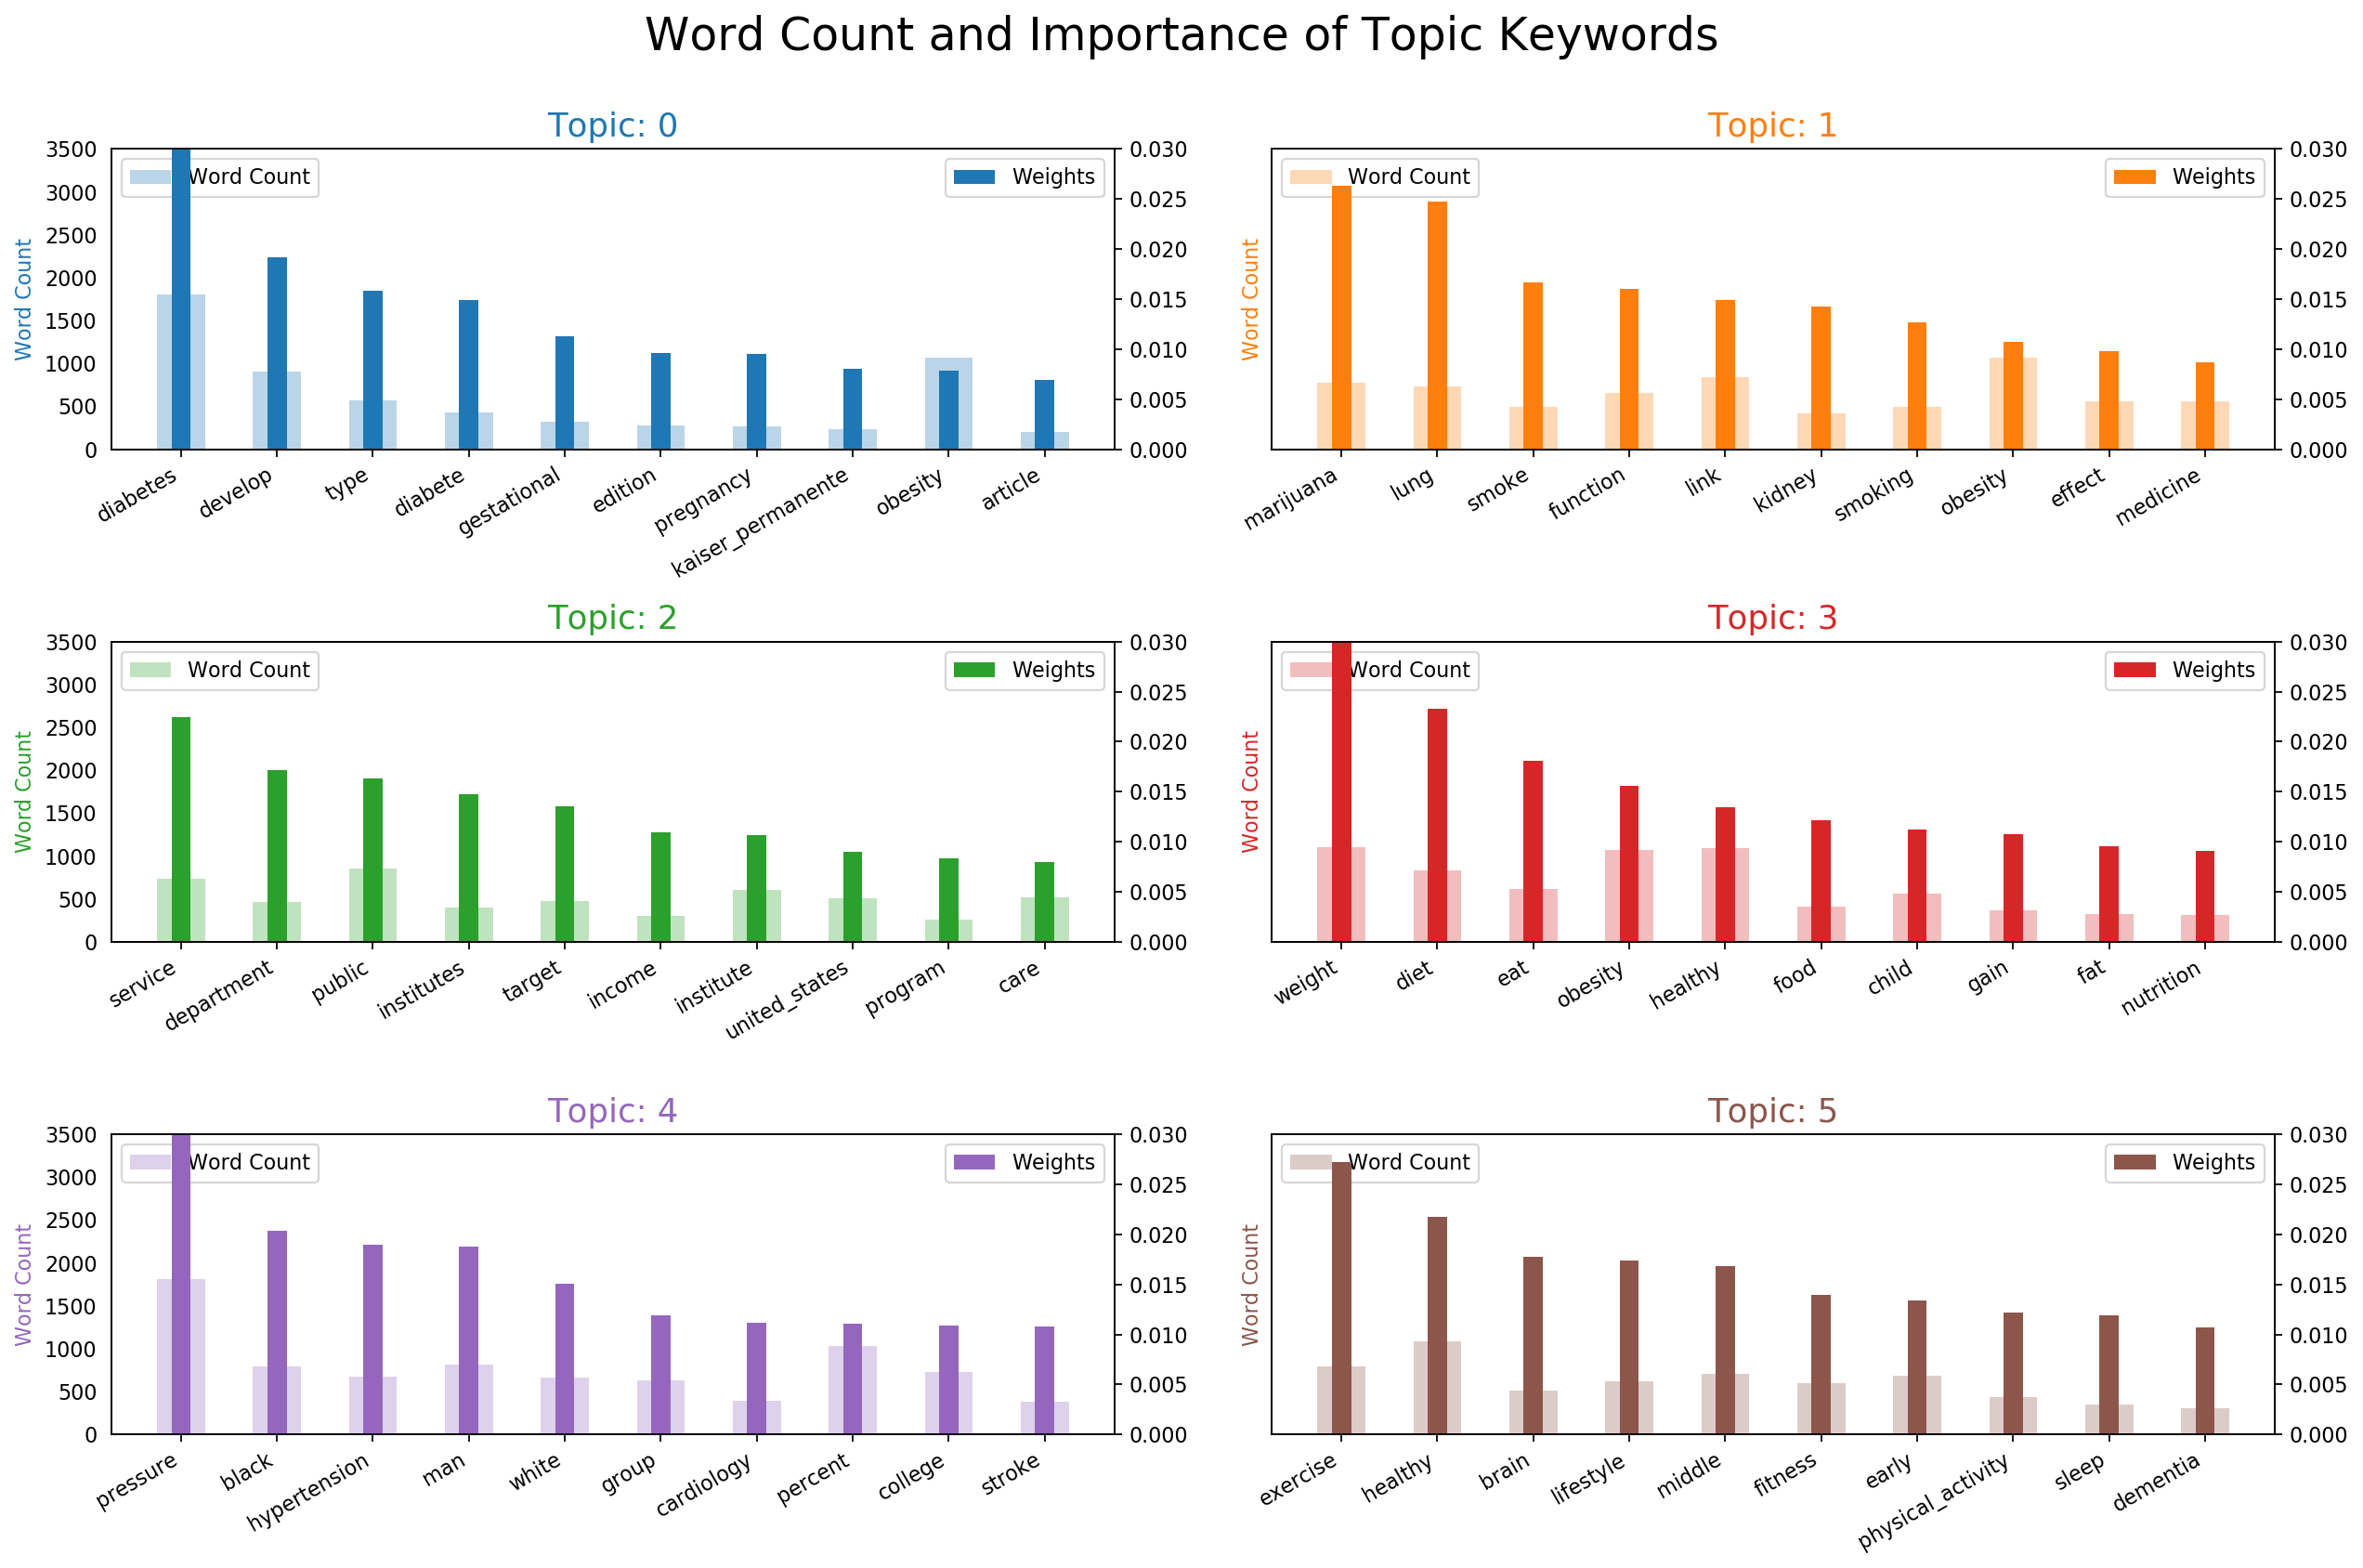

In [38]:
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors

visualize_topics = optimal_model_LDAMallet.show_topics(formatted=False)
data_flat = [w for w_list in texts_out_2 for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in visualize_topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

visualize_topics_df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=visualize_topics_df.loc[visualize_topics_df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=visualize_topics_df.loc[visualize_topics_df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(visualize_topics_df.loc[visualize_topics_df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   

# save the figure
plt.savefig('output/lda_mallet/LDAMallet_wordcount_weight.png', dpi=300, bbox_inches='tight')

plt.show()

### Visualize topics using T-SNE

"One very popular method for visualizing document similarity is to use t-distributed stochastic neighbor embedding, t-SNE. Scikit-learn implements this decomposition method as the sklearn.manifold.TSNE transformer. By decomposing high-dimensional document vectors into 2 dimensions using probability distributions from both the original dimensionality and the decomposed dimensionality, t-SNE is able to effectively cluster similar documents. By decomposing to 2 or 3 dimensions, the documents can be visualized with a scatter plot."


Text from: <https://www.scikit-yb.org/en/latest/api/text/tsne.html>

Resources
* <https://www.datacamp.com/community/tutorials/introduction-t-sne>
* <https://www.programmersought.com/article/90321584021/>


Scikit-learn has an implementation of t-SNE available, and you can check its documentation here. It provides a wide variety of tuning parameters for t-SNE, and the most notable ones are:

* n_components (default: 2): Dimension of the embedded space.
* perplexity (default: 30): The perplexity is related to the number of nearest neighbors that are used in other manifold learning algorithms. Consider selecting a value between 5 and 50.
* early_exaggeration (default: 12.0): Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them.
* learning_rate (default: 200.0): The learning rate for t-SNE is usually in the range (10.0, 1000.0).
* n_iter (default: 1000): Maximum number of iterations for the optimization. Should be at least 250.
* method (default: ‘barnes_hut’): Barnes-Hut approximation runs in O(NlogN) time. method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time.

In [39]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

print(type(optimal_model_LDAMallet))
print(type(bow_corpus))

# Get topic weights
topic_weights = []

## Next, we will get the main topics and their frequencies (i.e. weights) for each document
for i, row_list in enumerate(optimal_model_LDAMallet[bow_corpus]):
#     print(i)
#     print(type(i))
#    print(row_list)
#     print(type(row_list))
    topic_weights.append([w for i, w in row_list])
    ## w is the output expression
    ## for i,w in row_list; which is: i is the topic number, w is the weight
    


#print("*********************This is topic_weights:", topic_weights)

## Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values
print("*********************This is arr:", arr[0])
print(type(arr))

## Add original text to the end of the output
contents = pd.Series(texts_out_2)
# print("*********************This is contents:", contents)
#arr = pd.concat([arr, contents], axis=1)

## Keep the well separated points (optional)
##arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)
print(type(tsne_lda))
print(tsne_lda)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


## Resources: 
## https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#13.-t-SNE-Clustering-Chart
## https://stackoverflow.com/questions/2552287/python-enumerate-built-in-error-when-using-the-start-parameter
## https://distill.pub/2016/misread-tsne/

<class 'gensim.models.wrappers.ldamallet.LdaMallet'>
<class 'list'>
*********************This is arr: [0.11233211 0.15791616 0.34350834 0.13349613 0.14570615 0.10704111]
<class 'numpy.ndarray'>
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 734 samples in 0.010s...
[t-SNE] Computed neighbors for 734 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 734 / 734
[t-SNE] Mean sigma: 0.084722
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.282890
[t-SNE] KL divergence after 1000 iterations: 0.459078
<class 'numpy.ndarray'>
[[ 9.628012  -8.265264 ]
 [-0.3082569 -3.1799695]
 [ 0.7580062 -4.188039 ]
 ...
 [-1.9745378 -8.722623 ]
 [ 7.4757147  8.496599 ]
 [ 2.2671094 -2.706728 ]]


Loading BokehJS ...

### Tethne for Network Analysis

In [1]:
## Tethne is not working...but here are my attempts to make it work. 

## from tethne.model.corpus import mallet
## pip3 install tethne --pre
## If pip install tethne doesn't work, download an unzip the Tethne file (see linkin Resources) 
## Save the Tethne zip file into a Tools folder (see path I used below)
## tethne_mallet_path = C:\Users\keg827\Tools\tethne-0.8.1.dev12
## Then use anaconda prompt to cd /path/to/unzipped/tethne-x.y.z and type in python setup.py install


## Resources
## http://diging.github.io/tethne/doc/0.6.1-beta/installation.html
## http://diging.github.io/tethne/tutorial.gensim.html#let-tethne-talk-to-gensim


In [11]:
## If ## pip3 install tethne --pre doesn't work then...

## Provide a Path to Tethne Mallet File
#os.environ.update({'TETHNE_MALLET_HOME':r'C:\Users\keg827\Tools\tethne-0.8.1.dev12'}) 
## You should update this path as per the path of Mallet directory on your system.
#tethne_mallet_path = r'C:\Users\keg827\Tools\tethne-0.8.1.dev12\tethne\bin\mallet-2.0.7\bin\mallet' 
## You should update this path as per the path of Mallet directory on your system.
#print(tethne_mallet_path)

## Resources
## http://diging.github.io/tethne/doc/0.6.1-beta/installation.html


In [1]:
## Check bow_corpus and assign to variable called identifiers
# identifiers = range(len(bow_corpus))
# print(identifiers)

In [2]:
## Load a potentially pretrained model from disk.
# LDAModel = LdaModel.load('lda_checkpoint/gensim_tutorial_topic_model.lda')

In [3]:
## Open identifiers pickle file

# file_name = "output/loading/identifiers.pkl"

# open_file = open(file_name, "rb")
# identifiers = pickle.load(open_file)
# open_file.close()

In [4]:
# from tethne import gensim_to_theta_featureset
# theta = gensim_to_theta_featureset(LDAModel, bow_corpus, identifiers)

## Inspect output as needed
# print(theta)


In [5]:
## Save theta
## Save the list as a .pkl file

# file_name = "output/lda_mallet/theta.pkl"

# open_file = open(file_name, "wb")
# pickle.dump(theta, open_file, protocol=4)
# open_file.close()

In [6]:
## Open theta pickle file

# file_name = "output/lda_mallet/theta.pkl"

# open_file = open(file_name, "rb")
# theta = pickle.load(open_file)
# open_file.close()

In [7]:
# import networkx as nx
# from tethne import feature_cooccurrence
# graph = feature_cooccurrence(theta, dictionary, min_weight=0.05)
# print(graph)



In [8]:
# import tethne.writers as wr
# ## wr.graph.to_graphml(graph, 'output/lda_mallet/mymodel.gml')
# wr.graph.write_graphml(graph, 'output/lda_mallet/mymodel.graphml')



In [9]:
############# Current errors with Tethne and possible fixes ##############################



######## Problems with zip (now izip)##########

## Use this code wherever zip is used:

# try:
#     from itertools import izip
# except ImportError: 3.7
#     izip = zip

## Resource: https://codereview.stackexchange.com/questions/26271/import-izip-for-different-versions-of-python

## Example of where zip is used: 
## tethne-0.8.1.dev12 -> tethne -> plot -> __init__.py
## tethne-0.8.1.dev12 -> tethne -> analyze -> corpus
## tethne-0.8.1.dev12 -> tethne -> plot -> init.py
## tethne-0.8.1.dev12 -> tethne -> classes -> feature.py
## tethne-0.8.1.dev12 -> build -> lib -> tethne -> analyze -> corpus.py
## In this file you may also need to change zip to izip here: for year, N in izip(years, values):




######### Problems with Python 2 vs. 3 ##########

### Tethne is built with Python 2, but now we're on Python 3. 
## Need to add fix for str and range here:
## tethne-0.8.1.dev12 -> build -> lib -> tethne -> analyze -> corpus.py
## tethne-0.8.1.dev12 -> tethne -> classes -> feature.py
## tethne-0.8.1.dev12 -> tethne -> writers -> graph.py
## Add this code:  
# PYTHON_3 = sys.version_info[0] == 3
# if PYTHON_3:
#     unicode = str
#     xrange = range




######### Problems with cPickle and pickle #########

## Example of this pickle problem:
## tethne-0.8.1.dev12 -> tethne -> classes -> streaming.py
## comment out: import cPickle as pickle
## add in: import pickle



######## Problems with iter ##################

## Make these changes in this file: 
## tethne-0.8.1.dev12 -> tethne -> writers -> graph.py

## Old code listed first, new replacement code listed second

## for node,data in G.nodes_iter(data=True):
## for node,data in list(G.nodes(data=True)):

## for u,v,key,data in G.edges_iter(data=True, keys=True):
## for u,v,key,data in list(G.edges(data=True, keys=True)):

## for u,v,data in G.edges_iter(data=True):
## for u,v,data in list(G.edges(data=True)):

## for k,v in n[1].iteritems():
## for k,v in n[1].items():

## for k,v in e[2].iteritems():
## for k,v in e[2].items():
            
## for key, value in node_attribs.iteritems():
## for key, value in node_attribs.items():

## for attrib, value in edge[3].iteritems():
## for attrib, value in edge[3].items():

## for attrib, value in edge[2].iteritems():
## for attrib, value in edge[2].items():



## Make these changes in this file: 
## tethne-0.8.1.dev12 -> tethne -> model-> __init__.py 

## Old code listed first, new replacement code listed second

## for key, value in kwargs.iteritems():
## for key, value in kwargs.items():

## for key, value in kwargs.iteritems():
## for key, value in kwargs.items():


####### Problems with iter and graph.node ###########

## Make these changes in this file: 
## tethne-0.8.1.dev12 -> tethne -> netowrks -> base.py 

## Old code listed first, new replacement code listed second

## for combo, count in pairs.iteritems():
## for combo, count in pairs.items():

## for k, attrs in node_attrs.iteritems():
## for k, attrs in node_attrs.items():

## if k in graph.node:
## if k in graph.nodes:

## graph.node[k].update(attrs)
## graph.nodes[k].update(attrs)
            
## for paper, feature in featureset.iteritems():
## for paper, feature in featureset.items():
        
## for elem, papers in featureset.with_feature.iteritems():
## for elem, papers in featureset.with_feature.items():       
        
## for combo, features in pairs.iteritems():
## for combo, features in pairs.items():        
        
## graph.node[node][attr] = value
## graph.nodes[node][attr] = value
        
## for paper, feature in featureset.iteritems():
## for paper, feature in featureset.items():
        
        
## Resources:
## https://stackoverflow.com/questions/58518554/attributeerror-graph-object-has-no-attribute-node        
## #https://stackoverflow.com/questions/33734836/graph-object-has-no-attribute-nodes-iter-in-networkx-module-python      
        

  
    

######### After all fixes are made ##############

## After each fix is made or all fixes are made, do this in anaconda prompt:  python setup.py install



######## Functions of Note for my project ##############

# def gensim_to_theta_featureset(model, corpus, identifiers):
#     theta = FeatureSet()
#     for idx, doc in zip(identifiers, bow_corpus):
#         theta.add(idx, Feature(model[doc]))
#     return theta

# ## Call the function as needed
# theta = gensim_to_theta_featureset(model=optimal_model_LDAMallet, corpus=bow_corpus, identifiers= identifiers)
# print(theta)

## The function gensim_to_theta_featureset is in tethne-0.8.1.dev12 -> tethne -> model -> corpus -> gensim lda
## To find where functions are, go to tethne-0.8.1.dev12 -> tethne -> build -> tethne -> __init__.py


In [ ]:
## https://gist.github.com/quadrismegistus/eb2360026afce4ef4e57872146369091
#from gensim.test.utils import common_texts
# from gensim.models import Word2Vec

# model = Word2Vec(sentences=texts_out_2, window=5, min_count=1, workers=4)
# model.save("output/word2vec/ldaword2vec.model")

In [ ]:
# my_words = texts_out_2

# # The number of connections we want: either as a factor of the number of words or a set number
# num_top_conns = len(my_words) * 2 


In [ ]:
#######

# Make a list of all word-to-word distances [each as a tuple of (word1,word2,dist)]
# dists=[]

# ## Method 1 to find distances: use gensim to get the similarity between each word pair
# for i1,word1 in enumerate(my_words):
#     print(i1)
#     print(word1)
#     for i2,word2 in enumerate(my_words):
#         if i1>=i2: continue
#         cosine_similarity = model.similarity(word1,word2)
#         cosine_distance = 1 - cosine_similarity
#         dist = (word1, word2, cosine_distance)
#         dists.append(dist)

# ## Or, Method 2 to find distances: use scipy (faster)
# from scipy.spatial.distance import pdist,squareform
# Matrix = np.array([model[word] for word in my_words])
# dist = squareform(pdist(Matrix,'cosine'))
# for i1,word1 in enumerate(my_words):
#     for i2,word2 in enumerate(my_words):
#         if i1>=i2: continue
#         cosine_distance = Matrix[i1, i2]
#         dist = (word1, word2, cosine_distance)
#         dists.append(dist)

# ######

# # Sort the list by ascending distance
# dists.sort(key=lambda _tuple: _tuple[-1])

# # Get the top connections
# top_conns = dists[:num_top_conns]

# # Make a network
# import networkx as nx
# g = nx.Graph()
# for word1,word2,dist in top_conns:
#     weight = 1 - dist # cosine similarity makes more sense for edge weight
#     g.add_edge(word1, word2, weight=float(weight))

# # Write the network
# nx.write_graphml(g, 'my-semantic-network.graphml')